In [1]:
import numpy as np
import torch
import torchvision
import matplotlib.pyplot as plt

from torch import nn
from torch.utils.data import TensorDataset, DataLoader

import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder

from sklearn.model_selection import train_test_split
import sklearn.metrics as skm
from sklearn.metrics import f1_score

import seaborn as sn

from os import listdir
from PIL import Image
from collections import defaultdict

from IPython.display import display, clear_output, Image as IPython_Image

# Data loading

In [2]:
IMAGE_PATH = '../data/images'
LABEL_PATH = '../data/annotations'

In [3]:
def number_of_classes():
    return len(listdir(LABEL_PATH))

In [4]:
def get_class_map():
    ret = {}

    i = 0
    for fname in listdir(LABEL_PATH):
        img_class, _ = fname.split('.')
        ret[img_class] = i
        i += 1

    return ret

In [5]:
def get_dataloader(bs=256, train_fr=.6, max_images_per_class=1e9, transformations=None):
    
    # by default only transform to tensor
    if transformations is None:
        transformations = transforms.Compose([transforms.ToTensor()])
    
    # mapping from class names to integers
    class_map = get_class_map()

    # create a dictionary to hold our label vectors
    n_classes = len(class_map.keys())
    img_to_class = defaultdict(lambda: np.zeros(n_classes))

    # another dictionary to hold the actual image data
    img_to_data = dict()
    
    # loop through all the annotations
    for fname in listdir(LABEL_PATH):
        img_class, _ = fname.split('.')
        print(f'Reading class: {img_class}')
        
        # open the annotation file
        with open(f'{LABEL_PATH}/{fname}', 'r') as fh:

            # get image ids from annotation file
            img_ids = fh.read().splitlines()
            
            # gather the images with labels
            for i, img_id in enumerate(img_ids):
                
                # let's not process images unnecessarily
                if not img_id in img_to_data:

                    img_path = f'{IMAGE_PATH}/im{img_id}.jpg'
                    img = Image.open(img_path)

                    # apply transformations
                    img_tensor = transformations(img.convert('RGB')).numpy() 

                    # append to dict
                    img_to_data[img_id] = img_tensor

                # get one-hot encoded vector of image classes
                img_classes = img_to_class[img_id]

                # add new class to image vector
                img_class_id = class_map[img_class]
                img_classes[img_class_id] = 1

                # store the updated vector back
                img_to_class[img_id] = img_classes

                if i >= max_images_per_class:
                    break

    # collect data to a single array
    X = []
    y = []
    for img_id in img_to_class.keys():
        X.append(img_to_data[img_id])
        y.append(img_to_class[img_id])
        
    print(len(X), len(y))
        
    X_train, X_tmp, y_train, y_tmp = train_test_split(X, y, train_size=train_fr, random_state=42)
    X_test, X_valid, y_test, y_valid = train_test_split(X_tmp, y_tmp, train_size=.5, test_size=.5, random_state=42)
    
    train_dataloader = DataLoader(TensorDataset(
        torch.tensor(X_train, dtype=torch.float),
        torch.tensor(y_train, dtype=torch.float)),
        shuffle=True,
        batch_size=bs)           

    valid_dataloader = DataLoader(TensorDataset(
        torch.tensor(X_valid, dtype=torch.float),
        torch.tensor(y_valid, dtype=torch.float)),
        shuffle=True,
        batch_size=bs)

    test_dataloader = DataLoader(TensorDataset(
        torch.tensor(X_test, dtype=torch.float),
        torch.tensor(y_test, dtype=torch.float)),
        shuffle=True,
        batch_size=bs)      

    return train_dataloader, valid_dataloader, test_dataloader

# Batch statistics

## Normalization values

Average batch statistic (bs=4096):
```
MEAN=(0.43642, 0.40083, 0.36744), STD=(0.30473, 0.29116, 0.29608)
```
Running batch statistic (bs=16):
```
MEAN=(0.43672, 0.40107, 0.36762), STD=(0.30139, 0.28781, 0.29236)
```

In [6]:
def avg_batch_statistics(dataloaders):
    
    means = []
    stds = []
    
    for dataloader in dataloaders:
        for idx, (batch, _) in enumerate(dataloader):
            batch = batch.numpy().reshape(-1, 3, 128, 128)
            means.append(np.average(batch, axis=(0,2,3)))
            stds.append(np.std(batch, axis=(0,2,3), ddof=1))    
        
    return np.array(means).mean(axis=0), np.array(stds).mean(axis=0)

def running_batch_statistics(dataloaders, momentum=.5):

    mean = 0
    var_ = 0
    
    for dataloader in dataloaders:
        for idx, (batch, _) in enumerate(dataloader):
            batch = batch.numpy().reshape(-1, 3, 128, 128)
            b_mean, b_var = np.average(batch, axis=(0,2,3)), np.var(batch, axis=(0,2,3))
            mean = momentum * mean + (1 - momentum) * b_mean
            var_ = momentum * var_ + (1 - momentum) * b_var

    return mean, np.sqrt(var_) # We need not divide by 255
    

if False:
    
    images_root = '../data/images2'
    fmt = lambda arr: ", ".join(["%.5f" % x for x in arr])
    
    # NB: RuntimeError: Found 0 files in subfolders of: ../data/images
    #     => Put images in any arbitrary subfolder structure like '../data/images/0'
    dataset = ImageFolder(root=images_root, transform=transforms.Compose([ transforms.ToTensor() ]))
    
    bs = 2**13
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=bs)
    mean, var_ = avg_batch_statistics([dataloader])
    print(f'\nAverage batch statistic (bs={bs}):\nMEAN=({fmt(mean)}), STD=({fmt(var_)})')
    
    bs = 2**4
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=bs)
    mean, var_ = avg_batch_statistics([dataloader])
    print(f'\nRunning batch statistic (bs={bs}):\nMEAN=({fmt(mean)}), STD=({fmt(var_)})')

## Batch statistics with CIFAR10 dataset

Correct normalization values for CIFAR-10 (https://github.com/kuangliu/pytorch-cifar/issues/19): 
```
(0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261)
```

In [7]:
if False:

    from torchvision.datasets import CIFAR10
    
    images_root = '../data/CIFAR10'    
    fmt = lambda arr: ", ".join(["%.5f" % x for x in arr])
    
    dataset = torchvision.datasets.CIFAR10(root=f'{images_root}/train/', train=True, download=True, transform=transforms.Compose([ transforms.ToTensor() ]))
    dataset2 = torchvision.datasets.CIFAR10(root=f'{images_root}/test/', train=False, download=True, transform=transforms.Compose([ transforms.ToTensor() ]))

    bs = 2**13
    dataloaders = [
        torch.utils.data.DataLoader(dataset, batch_size=bs),
        torch.utils.data.DataLoader(dataset2, batch_size=bs)
    ]
    mean, var_ = avg_batch_statistics(dataloaders)
    print(f'\nAverage batch statistic (bs={bs}):\nMEAN=({fmt(mean)}), STD=({fmt(var_)})')
    
    bs = 2**4
    dataloaders = [
        torch.utils.data.DataLoader(dataset, batch_size=bs),
        torch.utils.data.DataLoader(dataset2, batch_size=bs)
    ]
    mean, var_ = running_batch_statistics([dataloader, dataloader2])
    print(f'\nRunning batch statistic (bs={bs}):\nMEAN=({fmt(mean)}), STD=({fmt(var_)})')
    
    #(0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261)

# Models

In [8]:
class TwoLayerModel(nn.Module):
    def __init__(self, n_input, n_hidden1, n_hidden2, n_classes):
        super().__init__()
        self.bs = bs
        self.input_layer = nn.Linear(n_input, n_hidden1)
        self.hidden1 = nn.Linear(n_hidden1, n_hidden2)
        self.hidden2 = nn.Linear(n_hidden2, n_classes)
        self.relu = nn.ReLU()
        self.bn0 = nn.BatchNorm1d(n_input)
        self.bn1 = nn.BatchNorm1d(n_hidden1)
        self.bn2 = nn.BatchNorm1d(n_hidden2)

    def forward(self, x):
        x = self.bn0(x)
        x = self.input_layer(x)
        x = self.relu(x)
        x = self.bn1(x)
        x = self.hidden1(x)
        x = self.relu(x)
        x = self.bn2(x)
        x = self.hidden2(x)

        return x

In [9]:
class OneLayerModel(nn.Module):
    def __init__(self, n_input, n_hidden, n_classes):
        super().__init__()

        self.input_layer = nn.Linear(n_input, n_hidden)
        self.hidden = nn.Linear(n_hidden, n_classes)
        self.relu = nn.ReLU()
        self.bn0 = nn.BatchNorm1d(n_input)
        self.bn1 = nn.BatchNorm1d(n_hidden)

    def forward(self, x):
        x = self.bn0(x)
        x = self.input_layer(x)
        x = self.relu(x)
        x = self.bn1(x)
        x = self.hidden(x)

        return x

In [10]:
class ConvNetModel(nn.Module):
    def __init__(self, n_classes, keep_prob=.5):
        super(ConvNetModel, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=256, kernel_size=3, stride=1, padding=1), #(n samples, channels, height, width)
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(p=1-keep_prob))
        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=14, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(p=1-keep_prob))
        self.fc3 = nn.Linear(in_features=256*4*14, out_features=n_classes)
        
    def forward(self, x):
        x = x.reshape(-1, 3, 128, 128)
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.reshape(out.size(0), -1)  # Flatten for FC
        out = self.fc3(out)
        return out
    

# Training and evaluation functions

In [11]:
def evaluate(dataloader, model, criterion, device, threshold=0.5):
    model.eval()

    f1_scores = []
    losses = []

    with torch.no_grad():
        for batch in dataloader:
            X, y = batch
            X = X.to(device)
            y = y.to(device)
            y_pred = model(X)

            loss = criterion(y_pred, y)
            losses.append(loss)

            with torch.no_grad():
                score = f1_score(y_pred.cpu() > threshold, y.cpu() == 1, average='micro')
                f1_scores.append(score)

    model.train()

    return torch.mean(torch.tensor(losses)), torch.mean(torch.tensor(f1_scores))

In [12]:
def train(train_dataloader, valid_dataloader, model, optimizer, criterion, device, n_epochs=50, verbose=True):
    
    log = []
    
    model.train()

    if verbose:
        fmt = '{:<5} {:12} {:12} {:<9} {:<9}'
        print(fmt.format('Epoch', 'Train loss', 'Valid loss', 'Train F1', 'Valid F1'))

    for epoch in range(n_epochs):
        
        for i, batch in enumerate(train_dataloader):
            X, y = batch
            
            X = X.to(device)
            y = y.to(device)

            optimizer.zero_grad()
            y_pred = model(X)
            loss = criterion(y_pred, y)
            loss.backward()
            optimizer.step()
            
            clear_output(wait=True)
            display(f'Epoch: {epoch+1}, iteration: {i+1}, loss: {loss}')

        log.append(f'Epoch: {epoch+1}, loss: {loss}')

        if verbose:
            train_loss, train_score = evaluate(train_dataloader, model, criterion, device)
            valid_loss, valid_score = evaluate(valid_dataloader, model, criterion, device)

            fmt = '{:<5} {:03.10f} {:03.10f} {:02.7f} {:02.7f}'
            print(fmt.format(epoch, train_loss, valid_loss, train_score, valid_score))
            
    print('\n'.join(log))
    print('\nDone training')

In [133]:
def visualize_predictions(model, device, dataloader, mean=MEAN, std=STD, n_to_show=3, threshold=0.5):
    
    class_to_label = { v: k for k, v in get_class_map().items() }
    
    # https://discuss.pytorch.org/t/simple-way-to-inverse-transform-normalization/4821/5
    inv_transform = transforms.Compose([
        transforms.Normalize(mean = -1 * np.multiply(mean, std), std=np.divide(1, std))
    ])
    
    for i, batch in enumerate(dataloader):
        n_shown = 0
        
        X, y = batch
        X = X.to(device)

        y_pred = model(X) > threshold
        y = y == 1

        for i in range(len(y)):
            pred_classes = np.where(y_pred[i] == 1)[0]
            true_classes = np.where(y[i] == 1)[0]

            true_classes_str = ', '.join([class_to_label[i] for i in true_classes])
            pred_classes_str = ', '.join([class_to_label[i] for i in pred_classes])

            img = inv_transform(X[i].cpu())              # inverse transforms
            img = img.permute(2, 1, 0)                   # BGR -> RGB
            igm = img.numpy().reshape((128, 128, 3)).astype(np.uint8)
            
            plt.title(f'True: {true_classes_str}, Predictions: {pred_classes_str}')
            plt.imshow(img)
            plt.pause(0.001)

            if n_shown >= n_to_show:
                return

            n_shown += 1

In [134]:
def predict_X(fr, threshold=0.25):
    
    y_hat = fr > threshold
    
    return y_hat if (np.sum(y_hat) > 0) else fr == np.max(fr)

def predict(model, device, dataloader):
    
    ys_all = []  # Array of np.array(14) 
    y_hats_all = []
    
    for i, batch in enumerate(dataloader):
        
        Xs, ys = batch
        Xs = model(Xs.to(device))
        y_hats = np.apply_along_axis(predict_X, axis=1, arr=Xs.detach().numpy())
        
        y_hats_all.extend(y_hat for y_hat in y_hats)
        ys_all.extend(y.numpy() for y in ys==1)

    return np.array(ys_all), np.array(y_hats_all)

def visualize_confusion_matrix(y_true, y_pred, labels, file_path):

    plt.ioff()
    
    # Get confusion matrices
    cn_tensor = skm.multilabel_confusion_matrix(y_true, y_pred)
    
    # Get precision, recall, f1-score
    scores = skm.classification_report(y_true, y_pred, output_dict=True)

    fig, ax = plt.subplots(nrows=5, ncols=3,sharey=True, figsize=(20, 20), 
                           gridspec_kw={'hspace': 0.3, 'wspace': 0.0})
    gn = ['True Neg','False Pos','False Neg','True Pos']
    n = cn_tensor[0].sum()
    
    # Loop all labels
    for i, cn_matrix in enumerate(cn_tensor):

        j, k = int(i/3), i%3
        
        # Annotations
        annot = np.asarray(
            ['{}\n{:0.0f}\n{:.2%}'.format(gn[i], x, x/n) for i, x in enumerate(cn_matrix.flatten())]
        ).reshape(2,2)
        
        # Plot heatmap
        sn.heatmap(cn_matrix, annot=annot, fmt='', cmap='Blues', ax=ax[j, k])
        
        # Precision, recall, f1-score
        title = '{}\nprec.={:.3}, rec.={:.3}, f1={:.3}'.format(
            labels[i], scores[str(i)]['precision'], scores[str(i)]['recall'], scores[str(i)]['f1-score'])
        ax[j, k].set_title(title)
        
    plt.savefig(file_path, bbox_inches='tight')
    plt.close()

# Do the magic!

In [15]:
use_cuda = False
device = torch.device('cuda') if use_cuda else torch.device('cpu')

lr = 0.01
n_epochs = 2 #10
bs = 64 #256
n_classes = len(get_class_map().keys())

MEAN = (0.43672, 0.40107, 0.36762)
STD = (0.30139, 0.28781, 0.29236)

## Create and save / load dataloaders from disk

In [18]:
max_images_per_class = 10
#max_images_per_class = 1e9
affix = "_" + str(max_images_per_class) if max_images_per_class < 1e9 else ""

transformations = {
    'train' : transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=MEAN, std=STD)
        ]),
}
transformations['valid'] = transformations['test'] = transformations['train']

try:
    train_dataloader = torch.load(f'../data/train_dataloader{affix}.dat')
    valid_dataloader = torch.load(f'../data/valid_dataloader{affix}.dat')
    test_dataloader = torch.load(f'../data/test_dataloader{affix}.dat')
except:
    train_dataloader, valid_dataloader, test_dataloader = get_dataloader(bs=bs, transformations=transformations['train'], max_images_per_class=max_images_per_class)
    torch.save(train_dataloader, f'../data/train_dataloader{affix}.dat')
    torch.save(valid_dataloader, f'../data/valid_dataloader{affix}.dat')
    torch.save(test_dataloader, f'../data/test_dataloader{affix}.dat')

Reading class: tree
Reading class: female
Reading class: flower
Reading class: dog
Reading class: sea
Reading class: people
Reading class: portrait
Reading class: car
Reading class: clouds
Reading class: male
Reading class: river
Reading class: bird
Reading class: night
Reading class: baby
1377 1377


## Do the actual training

In [19]:
#model_path = '../data/TwoLayerModel_state.dict'
model_path = f'../data/ConvNetModel_state{affix}.dict'

#model = TwoLayerModel(128*128*3, 512, 256, n_classes)
model = ConvNetModel(n_classes=n_classes, keep_prob=.5)

criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9)

try:
    model.load_state_dict(torch.load(model_path))
    model.eval()
    print("Loaded model")
except:
    train(train_dataloader, valid_dataloader, model, optimizer, criterion, device, n_epochs=n_epochs)
    torch.save(model.state_dict(), model_path)

'Epoch: 2, iteration: 13, loss: 0.2765022814273834'

1     0.2801538408 0.2835752368 0.0000000 0.0000000
Epoch: 1, loss: 0.32968342304229736
Epoch: 2, loss: 0.2765022814273834

Done training


### Show some images with predictions

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


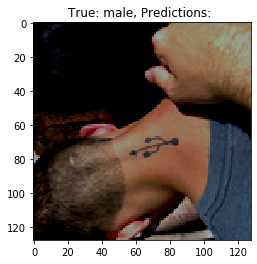

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


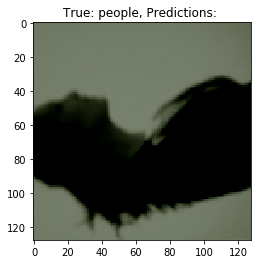

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


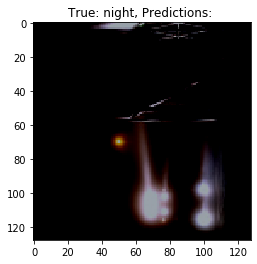

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


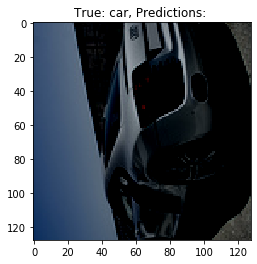

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


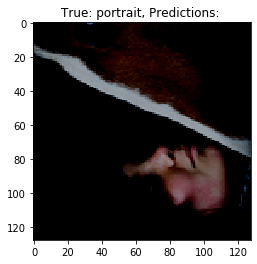

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


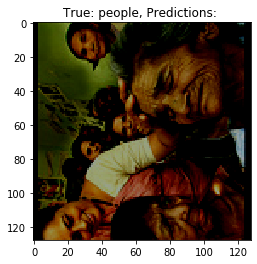

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


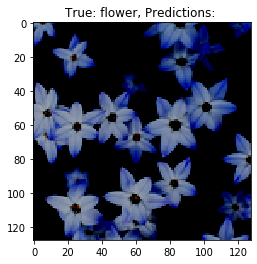

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


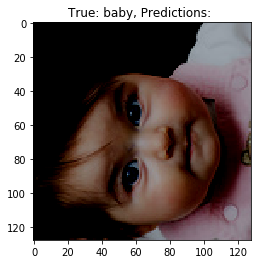

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


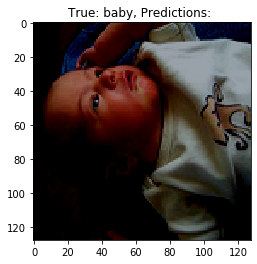

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


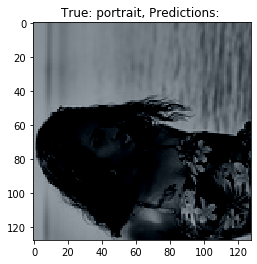

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


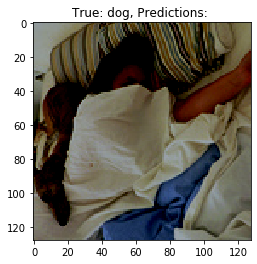

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


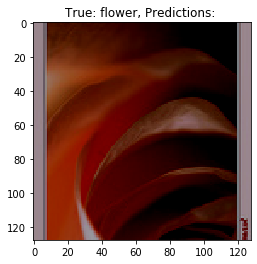

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


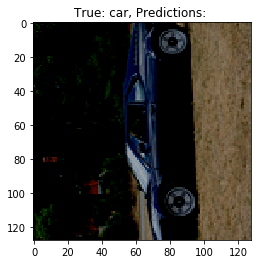

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


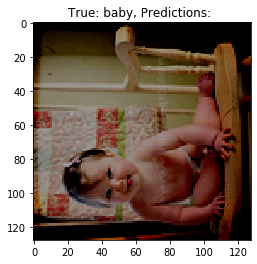

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


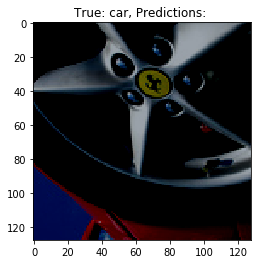

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


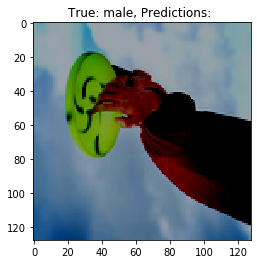

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


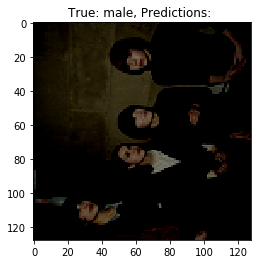

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


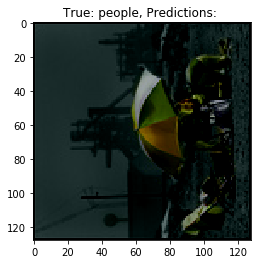

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


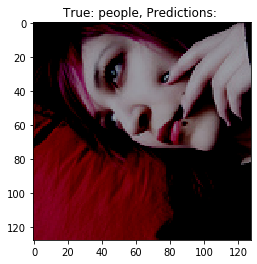

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


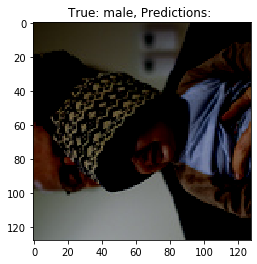

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


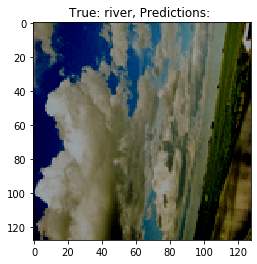

In [135]:
visualize_predictions(model, device, valid_dataloader, n_to_show=20)

### Confusion matrix

In [26]:
re_predict = False

if re_predict:

    # Predict
    y_true, y_pred = predict(model, device, valid_dataloader)
    np.save(f'../data/valid_true_labels{affix}.npy', y_true)
    np.save(f'../data/valid_pred_labels{affix}.npy', y_pred)
    
    # Save classification report
    with open(f'../data/valid_classification_report{affix}.txt', 'w') as file:
        file.write(skm.classification_report(y_true, y_pred))
    
    # Save confusion matrix plot
    labels = [k for k, v in get_class_map().items()]
    visualize_confusion_matrix(y_true, y_pred, labels, f'../data/valid_confusion_matrix{affix}.png')

In [27]:
# Show classification report
with open(f'../data/valid_classification_report{affix}.txt', 'r') as file:
    report = ''.join(file.readlines())
    print(report)

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.08      0.05      0.06        20
           2       0.33      0.03      0.06        29
           3       0.10      0.05      0.07        20
           4       0.15      0.39      0.21        18
           5       0.12      0.04      0.06        26
           6       0.00      0.00      0.00        24
           7       0.00      0.00      0.00        16
           8       0.45      0.25      0.32        20
           9       0.10      0.04      0.06        25
          10       0.16      0.35      0.22        20
          11       0.03      0.07      0.04        14
          12       0.41      0.88      0.56        24
          13       0.15      0.32      0.20        19

   micro avg       0.19      0.18      0.19       285
   macro avg       0.15      0.18      0.13       285
weighted avg       0.17      0.18      0.14       285
 samples avg       0.19   

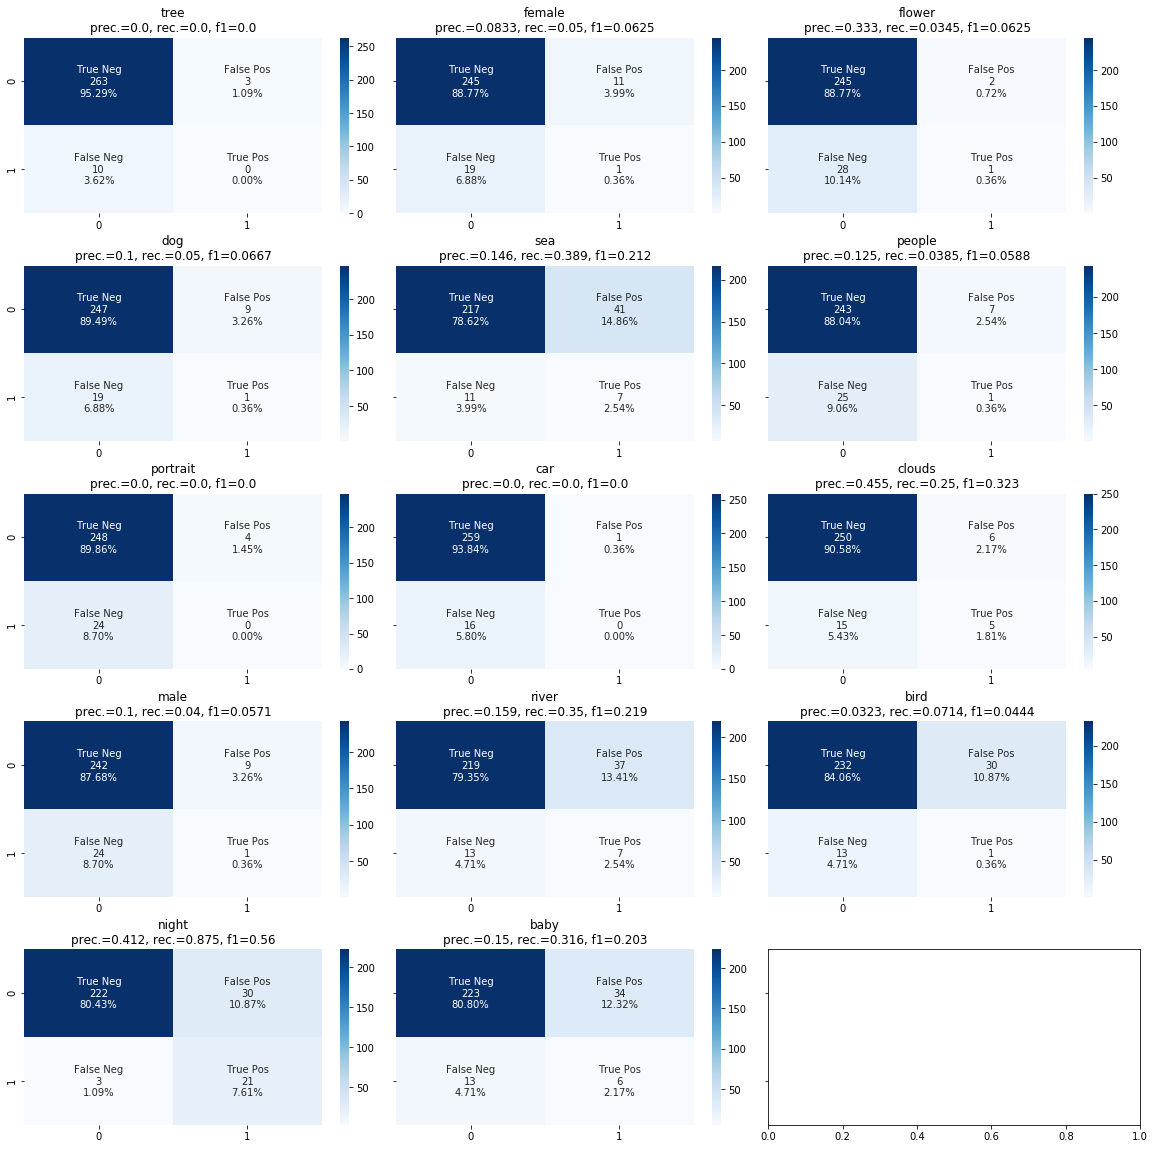

In [28]:
# Show confusion matrix plot
IPython_Image(filename=f'../data/valid_confusion_matrix{affix}.png', width=1000)